<a href="https://www.kaggle.com/code/dsptlp/synthetic-data-sonify?scriptVersionId=209820894" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# TODO
- for all services add activation channel
- in def deactivate_services(df,products_df,df_cancellation_reasons): increase chance of deact if around renewal date for any service that is not monthly
- add demographics table so can join to customer table on postal code

# Synthetic Data for Sonify
- Online Music Streaming Service

## Tables
- Renewals
- Products
- Deactivation Reason Codes
- Consumption
- Music Catalogue 

## Output
- Final Results Saved into SQLite DB

In [1]:
import os
import sys
import gc
import math
import random
import csv
import sqlite3
from datetime import datetime, timedelta
from time import strftime
import string 

# Data manipulation imports
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import relativedelta

# Database interaction imports
import networkx as nx

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# Suppress specific warning about use_inf_as_na
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

### CONFIGURATION

In [2]:
# Check if the notebook is running due to a scheduled event
run_type = os.getenv('KAGGLE_KERNEL_RUN_TYPE')
print(run_type)

#if run_type == 'Batch':
if run_type == 'Interactive':
    print("This notebook is running Interactive")
    
    # ==================================================
    # Create Products DataFrame
    # ==================================================
    products_df = pd.DataFrame({
    'Plan_ID': [1,2,3,4,5,6,7,8,9,10],
    'Product_Type': ['Bronze','Bronze','Bronze','Bronze','Silver','Silver','Silver','Silver','Gold','Gold'],
    'Product_Name': ['Bronze - Individual - Monthly',
                     'Bronze - Student - Monthly',
                     'Bronze - Duo - Monthly',
                     'Bronze - Family - Monthly',
                     'Silver - Individual - Annual',
                     'Silver - Student - Annual',
                     'Silver - Duo - Annual',
                     'Silver - Family - Annual',
                     'Gold - Individual - Quarterly',
                     'Gold - Student - Quarterly'],
    'Product_Term':  [1,1,1,1,12,12,12,12,3,3],
    'Product_Churn': [2,3,4,2, 6,12,12,12,3,3],
    'Product_MER': [12.99,6.99,17.99,20.99,12.99,6.99,17.99,20.99,12.99,6.99],
})        
 
    # Define start and end dates
    start_date = datetime(2021, 1, 31)  # Start date at the end of January
    end_date = datetime(2024, 9, 30)    # End date
    
     # ==================================================
    # BASE CONFIG
    # ==================================================
    first_month_start = '2021-01-01'
    first_month_end   = '2021-01-28'
    start_id = 100000
    count   = 10000
    counts = {
            1: 1000, 
            2: 500, 
            3: 500,
            4: 3000,
            5: 1000,
            6: 1000,
            7: 1000,
            8: 1000,
            9: 500,
            10: 500,
        }

    # ==================================================
    # GA CONFIG
    # ==================================================
    ga_count = 1400
    ga_counts = {
            1: 300, 
            2: 200, 
            3: 200,
            4: 100,
            5: 100,
            6: 100,
            7: 100,
            8: 100,
            9: 100,
            10: 100
        }

    
else:
    print("This notebook is running not Interactive")
    
    # ==================================================
    # Create Products DataFrame
    # ==================================================
    products_df = pd.DataFrame({
    'Plan_ID': [1,2,3],
    'Product_Type': ['Paid','Paid','Paid'],
    'Product_Name': ['Bronze','Silver','Gold'],
    'Product_Term': [1,3,12],
    'Product_Churn': [2,6,10],
    'Product_MER': [2,6,24],
})
    
    # Define start and end dates
    start_date = datetime(2021, 1, 31)  # Start date at the end of January
    end_date = datetime(2024, 9, 30)    # End date
    
    # ==================================================
    # BASE CONFIG
    # ==================================================
    first_month_start = '2021-01-01'
    first_month_end   = '2021-01-28'
    start_id = 100000
    count   = 1000000
    counts = {
            1: 300000, 
            2: 300000, 
            3: 400000  
        }

    # ==================================================
    # GA CONFIG
    # ==================================================
    ga_count = 7000
    ga_counts = {
            1: 3000, 
            2: 2000, 
            3: 2000  
        }

Batch
This notebook is running not Interactive


In [3]:
def generate_sequential_ids(start, count):
    """
    Generate a list of sequential IDs starting from 'start' with a given 'count'.

    Parameters:
    start (int): The starting ID (inclusive).
    count (int): The number of sequential IDs to generate.

    Returns:
    list: A list of sequential IDs.
    """
    if count <= 0:
        raise ValueError("Count must be greater than 0.")
    return list(range(start, start + count))


In [4]:
def generate_custom_repeated_range(counts):
    """
    Generate a list where each number is repeated based on the counts specified in the input dictionary.

    Parameters:
    counts (dict): A dictionary where keys are the numbers and values are how many times each number should be repeated.

    Returns:
    list: A list where each number appears the specified number of times.
    """
    result = []
    
    for number, count in counts.items():
        if count < 0:
            raise ValueError(f"Count for number {number} must be non-negative.")
        result.extend([number] * count)
    
    return result

In [5]:
def generate_random_dates(start_date, end_date, count):
    """
    Generate a list of random dates between start_date and end_date.

    Parameters:
    start_date (str): The start date in 'YYYY-MM-DD' format.
    end_date (str): The end date in 'YYYY-MM-DD' format.
    count (int): The number of random dates to generate.

    Returns:
    list: A list of random dates.
    """
    start_u = datetime.strptime(start_date, '%Y-%m-%d').timestamp()
    end_u = datetime.strptime(end_date, '%Y-%m-%d').timestamp()

    random_dates = np.random.uniform(start_u, end_u, count)
    return [datetime.fromtimestamp(date).strftime('%Y-%m-%d') for date in random_dates]

In [6]:
def generate_base(first_month_start, first_month_end, counts,count,start_id):
    
    sequential_ids = generate_sequential_ids(start_id, count)
    
    custom_list = generate_custom_repeated_range(counts)
    random_dates = generate_random_dates(first_month_start, first_month_end, count)

    # Create DataFrame
    base_start_df = pd.DataFrame({'Sub_ID': sequential_ids, 'Plan_ID': custom_list, 'PlanStart': random_dates})

    #SET EOP
    EOP = datetime.strptime(first_month_start, '%Y-%m-%d')
    EOP += relativedelta(months=0)    
    EOP = EOP + relativedelta(day=31)
    base_start_df['EOP'] = EOP.strftime('%Y-%m-%d')

    #Set All Active
    base_start_df['Status'] = 'Active'
    
    #Deact Reason ID
    base_start_df['Reason_ID'] = None

    # Add Term Based on Plan
    base_start_df = pd.merge(base_start_df, products_df, left_on='Plan_ID', right_on='Plan_ID', how='inner')

    # Convert 'PlanStart' column to datetime
    base_start_df['PlanStart'] = pd.to_datetime(base_start_df['PlanStart'])

    # Add 'PlanEnd' by adding the exact number of months using relativedelta
    base_start_df['PlanEnd'] = base_start_df.apply( lambda row: row['PlanStart'] + relativedelta(months=row['Product_Term']), axis=1)

    #Final DataFrame
    base_start_df = base_start_df[['EOP','Sub_ID','Plan_ID','PlanStart','PlanEnd','Status','Reason_ID']]
    
    return base_start_df

In [7]:
# Assign weights (higher weight means higher probability of selection)
# Let's say we want 'Non-payment' (NV003) to be selected more often, so we give it a higher weight.
act_channel_weights = [1, 1, 1, 1, 1, 1, 5, 1]  # NV003 (Non-payment) gets weight of 5, others get weight of 1

# Voluntary and non-voluntary cancellation reason codes
data = {
    'Act_Code': ['A001', 'A002', 'A003', 'A004', 'AV001', 'AV002', 'AV003', 'AV004'],
    'Channel_Description': [
        'Website - 1',        # Voluntary
        'Website - 2',            # Voluntary
        'Website - 3',          # Voluntary
        'AC',        # Voluntary
        'AC',       # Non-voluntary
        'AC',         # Non-voluntary
        'Facebook',                         # Non-voluntary
        'Google'    # Non-voluntary
    ],
    'Category': [
        'Online', 'Online', 'Online', 'OEM','OEM', 'OEM', 'Aff', 'Aff'
    ],
    'Act_ID': list(range(10000, 10008))  # Sequential reason_code_id starting from 10000
}

# Create a DataFrame
df_activation_channel = pd.DataFrame(data)
df_activation_channel

,Act_Code,Channel_Description,Category,Act_ID
0,A001,Website - 1,Online,10000
1,A002,Website - 2,Online,10001
2,A003,Website - 3,Online,10002
3,A004,AC,OEM,10003
4,AV001,AC,OEM,10004
5,AV002,AC,OEM,10005
6,AV003,Facebook,Aff,10006
7,AV004,Google,Aff,10007


In [8]:
# Assign weights (higher weight means higher probability of selection)
# Let's say we want 'Non-payment' (NV003) to be selected more often, so we give it a higher weight.
weights = [1, 1, 1, 1, 1, 1, 5, 1]  # NV003 (Non-payment) gets weight of 5, others get weight of 1

# Voluntary and non-voluntary cancellation reason codes
data = {
    'Reason_Code': ['V001', 'V002', 'V003', 'V004', 'NV001', 'NV002', 'NV003', 'NV004'],
    'Reason_Description': [
        'Customer moved to competitor',        # Voluntary
        'Product no longer needed',            # Voluntary
        'Found a better alternative',          # Voluntary
        'Dissatisfaction with service',        # Voluntary
        'Service terminated by company',       # Non-voluntary
        'Fraudulent account activity',         # Non-voluntary
        'Non-payment',                         # Non-voluntary
        'Violation of terms and conditions'    # Non-voluntary
    ],
    'Category': [
        'Voluntary', 'Voluntary', 'Voluntary', 'Voluntary',
        'Non-voluntary', 'Non-voluntary', 'Non-voluntary', 'Non-voluntary'
    ],
    'Reason_ID': list(range(10000, 10008))  # Sequential reason_code_id starting from 10000
}

# Create a DataFrame
df_cancellation_reasons = pd.DataFrame(data)

In [9]:
def update_renewal_dates(df,products_df):
    """
   
    """
    # Add Term Based on Plan
    df = pd.merge(df, products_df, left_on='Plan_ID', right_on='Plan_ID', how='inner')
    
    # Create a new column 'ComparisonResult', set to 1 if 'Date1' > 'Date2', otherwise 0
    df['Renewal_Flag'] = (df['EOP'] > df['PlanEnd']).astype(int)
    
    # Add 'PlanEnd' by adding the exact number of months using relativedelta
    df['PlanEnd_new'] = df.apply( lambda row: row['PlanStart'] + relativedelta(months=row['Product_Term']*2), axis=1)

    # Add 'PlanEnd' by adding the exact number of months using relativedelta
    df['PlanStart_new'] = df.apply( lambda row: row['PlanStart'] + relativedelta(months=row['Product_Term']), axis=1)
    
    df.loc[df["Renewal_Flag"] == 1, "PlanStart"] = df['PlanStart_new']
    df.loc[df["Renewal_Flag"] == 1, "PlanEnd"] = df['PlanEnd_new']
    
    return df[['EOP','Sub_ID','Plan_ID','PlanStart','PlanEnd','Status','Reason_ID']]

In [10]:
# Randomly pick a reason code based on the specified weights
def pick_reason_code(df, weights):
    # Get the list of reason codes
    reason_codes = df['Reason_ID'].tolist()
    
    # Randomly select a reason code according to the weights
    selected_reason_code = random.choices(reason_codes, weights=weights, k=1)[0]
    
    # Return the selected reason code and its description
    selected_row = df[df['Reason_Code'] == selected_reason_code]
    #return selected_row, selected_reason_code
    return selected_reason_code

In [11]:
def deactivate_services(df,products_df,df_cancellation_reasons):
    
     # Add Term Based on Plan
    df = pd.merge(df, products_df, left_on='Plan_ID', right_on='Plan_ID', how='inner')
    
    # Add deact random
    df['Status_Rand_new'] = df.apply( lambda row: random.randrange(0, 100, 1), axis=1)
    
    # Example: pick a reason code 10 times
    #for _ in range(10):
    for _ in range(len(df)):
        cancel_reason_id = pick_reason_code(df_cancellation_reasons, weights)
    
    # Add deact random
    df['Status_New'] = 'Active'
    df.loc[df["Status_Rand_new"] <= df["Product_Churn"], "Status_New"] = 'Closed'
    df['Status'] = df['Status_New']
    df['Reason_ID'] = cancel_reason_id
    
    # 
    df.loc[df["Status"] == 'Active', 'Reason_ID'] = None
    
    return df[['EOP','Sub_ID','Plan_ID','PlanStart','PlanEnd','Status','Reason_ID']]

In [12]:
def get_eomonth(date_str, date_format='%Y-%m-%d'):
    """
    This function takes a date string and returns the end of the month (EOM) for that date as a string.
    
    Parameters:
    - date_str: the input date as a string.
    - date_format: the format of the input date string. Default is '%Y-%m-%d'.
    
    Returns:
    - The end of the month date as a string in the same format.
    """
    # Parse the date string into a datetime object
    date_obj = datetime.strptime(date_str, date_format)
    
    # Calculate the end of the month using relativedelta
    eom_date = date_obj + relativedelta(day=31)  # Set the day to the last day of the month
    
    # Return the EOM date as a string in the same format
    return eom_date.strftime(date_format)

In [13]:
def get_first_of_month(date_str, date_format='%Y-%m-%d'):
    """
    This function takes a date string and returns the first day of the month for that date as a string.
    
    Parameters:
    - date_str: the input date as a string.
    - date_format: the format of the input date string. Default is '%Y-%m-%d'.
    
    Returns:
    - The first day of the month as a string in the same format.
    """
    # Parse the date string into a datetime object
    date_obj = datetime.strptime(date_str, date_format)
    
    # Replace the day to be the first of the month
    first_of_month = date_obj.replace(day=1)
    
    # Return the first of the month date as a string in the same format
    return first_of_month.strftime(date_format)

#### RUN OVER MONTHS

In [14]:
# Build First Month
base_start_df = generate_base(first_month_start, first_month_end, counts, count,start_id)

first_run = 0

# Initialize current_date with start_date
current_date = start_date

# Loop through dates with monthly increments
while current_date <= end_date:
    
    print("=============================================================================================")
    print(current_date)
       
    if first_run == 0:
        old_month_df = base_start_df[base_start_df['EOP'] == current_date.strftime('%Y-%m-%d')].copy()
        df_final = base_start_df
        first_run = 1
    else:
        old_month_df = df_final[df_final['EOP'] == current_date.strftime('%Y-%m-%d')].copy()
        old_month_df = old_month_df[old_month_df['Status'] == 'Active']
                   
    # Increment the date by one month
    current_date += relativedelta(months=1)    
    current_date = current_date + relativedelta(day=31)  # This will correctly handle the last day of each month
    
    new_month_df = old_month_df.copy()
    new_month_df['EOP'] = current_date.strftime('%Y-%m-%d')
    
    #Set Renewal Dates
    new_month_df = update_renewal_dates(new_month_df,products_df)
    
    #Deactivate Services
    new_month_df = deactivate_services(new_month_df,products_df,df_cancellation_reasons)
    
    #Add New Services
    start_id = 1 + df_final['Sub_ID'].max()
    add_df = generate_base(get_first_of_month(current_date.strftime('%Y-%m-%d')), current_date.strftime('%Y-%m-%d'), ga_counts, ga_count,start_id)
        
    # Concatenating along rows
    df_final = pd.concat([df_final, add_df], ignore_index=True)         
    df_final = pd.concat([df_final, new_month_df], ignore_index=True)

2021-01-31 00:00:00


/tmp/ipykernel_17/3330652375.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, new_month_df], ignore_index=True)


2021-02-28 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2021-03-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2021-04-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2021-05-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2021-06-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2021-07-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2021-08-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2021-09-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2021-10-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2021-11-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2021-12-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-01-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-02-28 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-03-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-04-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-05-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-06-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-07-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-08-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-09-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-10-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-11-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2022-12-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-01-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-02-28 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-03-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-04-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-05-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-06-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-07-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-08-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-09-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-10-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-11-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2023-12-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2024-01-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2024-02-29 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2024-03-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2024-04-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2024-05-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2024-06-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2024-07-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2024-08-31 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


2024-09-30 00:00:00


/tmp/ipykernel_17/3330652375.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, add_df], ignore_index=True)


## GENRATE CUSTOMER LIST

In [15]:
# Function to generate a random postal code
def generate_postal_code():
    letters = string.ascii_uppercase
    return (
        random.choice(letters) + 
        str(random.randint(1, 9)) + 
        random.choice(letters) + 
        ' ' +
        str(random.randint(1, 9)) + 
        random.choice(letters) + 
        str(random.randint(1, 9))
    )

In [16]:
# Sample data
sub_id_list = df_final['Sub_ID'].unique()
customer_df = pd.DataFrame(sub_id_list, columns=['Customer_ID'])

# Extended lists of names and provinces
provinces = [
    'Ontario', 'Quebec', 'British Columbia', 'Alberta', 'Manitoba', 'Saskatchewan',
    'Nova Scotia', 'New Brunswick', 'Newfoundland and Labrador', 'Prince Edward Island'
]
first_names = [
    'John', 'Emily', 'Michael', 'Jessica', 'David', 'Sarah', 'Chris', 'Ashley',
    'Daniel', 'Megan', 'Andrew', 'Rachel', 'James', 'Olivia', 'Matthew', 'Sophia',
    'Joseph', 'Isabella', 'Ryan', 'Ava', 'Joshua', 'Mia', 'Alexander', 'Amelia',
    'Ethan', 'Emma', 'Liam', 'Grace', 'Noah', 'Hannah', 'Lucas', 'Abigail', 
    'Benjamin', 'Ella', 'Samuel', 'Chloe', 'Gabriel', 'Lily', 'Henry', 'Victoria',
    'Jack', 'Aria', 'Nathan', 'Mason', 'Aiden', 'Sophie', 'Jacob', 'Evelyn',
    'William', 'Charlotte', 'Logan', 'Zoe', 'Leo', 'Scarlett', 'Elijah', 'Luna'
]
last_names = [
    'Smith', 'Johnson', 'Williams', 'Brown', 'Jones', 'Garcia', 'Martinez', 'Taylor',
    'Anderson', 'Thomas', 'Jackson', 'White', 'Harris', 'Martin', 'Thompson', 'Moore',
    'Allen', 'Young', 'King', 'Wright', 'Hill', 'Scott', 'Green', 'Adams', 'Baker',
    'Gonzalez', 'Nelson', 'Carter', 'Mitchell', 'Perez', 'Roberts', 'Turner', 'Phillips',
    'Campbell', 'Parker', 'Evans', 'Edwards', 'Collins', 'Stewart', 'Sanchez', 'Morris',
    'Rogers', 'Reed', 'Cook', 'Morgan', 'Bell', 'Murphy', 'Bailey', 'Rivera', 'Cooper',
    'Richardson', 'Cox', 'Howard', 'Ward', 'Torres', 'Peterson', 'Gray', 'Ramirez'
]

# Assign random values for each field
customer_df['Country'] = 'Canada'
customer_df['Province'] = np.random.choice(provinces, len(customer_df))
customer_df['FirstName'] = np.random.choice(first_names, len(customer_df))
customer_df['LastName'] = np.random.choice(last_names, len(customer_df))
customer_df['PostalCode'] = [generate_postal_code() for _ in range(len(customer_df))]

# Construct emails based on first and last names
customer_df['email'] = customer_df['FirstName'].str.lower() + '.' + customer_df['LastName'].str.lower() + '@gmail.com'
customer_df.head(10)

,Customer_ID,Country,Province,FirstName,LastName,PostalCode,email
0,100000,Canada,Manitoba,Noah,Scott,W4M 2T2,noah.scott@gmail.com
1,100001,Canada,Manitoba,Amelia,Garcia,T7Z 3N3,amelia.garcia@gmail.com
2,100002,Canada,New Brunswick,Liam,Cox,V3W 6W9,liam.cox@gmail.com
3,100003,Canada,Quebec,Victoria,Howard,J8F 6L4,victoria.howard@gmail.com
4,100004,Canada,British Columbia,Luna,Murphy,Z3W 3K6,luna.murphy@gmail.com
5,100005,Canada,Prince Edward Island,Joseph,Taylor,Q4W 9M2,joseph.taylor@gmail.com
6,100006,Canada,Saskatchewan,Abigail,White,A9P 7I2,abigail.white@gmail.com
7,100007,Canada,Quebec,Jack,Edwards,X3E 3Z1,jack.edwards@gmail.com
8,100008,Canada,Manitoba,Mason,Phillips,H7W 7S1,mason.phillips@gmail.com
9,100009,Canada,Alberta,Chris,Johnson,R6D 3H1,chris.johnson@gmail.com


# GENERATE DEMOGRAPHIC LOOKUP DATA

In [17]:
# Extract unique postal codes
unique_postal_codes = customer_df['PostalCode'].unique()

# Define a list of PRIZM-like segments
prizm_segments = [
    'Urban Elite', 'Suburban Families', 'Rural Families', 'Young Professionals', 
    'Senior Citizens', 'Blue-Collar Workers', 'High-Income Professionals',
    'Diverse Suburbanites', 'College Towns', 'Affluent Empty-Nesters'
]

# Function to generate random demographic data including PRIZM segments
def generate_demographic_data_with_segments(postal_codes):
    data = []
    for postal_code in postal_codes:
        avg_income = round(np.random.uniform(30000, 120000), 2)  # Random income between 30k and 120k
        median_age = np.random.randint(20, 75)  # Median age between 20 and 75
        pop_density = round(np.random.uniform(50, 5000), 2)  # Population density between 50 and 5000
        prizm_segment = np.random.choice(prizm_segments)  # Randomly assign a PRIZM segment
        data.append([postal_code, avg_income, median_age, pop_density, prizm_segment])
    return data

# Create the demographic lookup table
demographics_df = pd.DataFrame(
    generate_demographic_data_with_segments(unique_postal_codes),
    columns=['PostalCode', 'AverageIncome', 'MedianAge', 'PopulationDensity', 'PRIZMSegment']
)

# Display the first few rows
demographics_df.head(10)

,PostalCode,AverageIncome,MedianAge,PopulationDensity,PRIZMSegment
0,W4M 2T2,66352.06,46,4248.54,Affluent Empty-Nesters
1,T7Z 3N3,56490.57,22,3467.46,High-Income Professionals
2,V3W 6W9,81254.67,25,3885.80,Blue-Collar Workers
3,J8F 6L4,57673.80,67,3798.33,Diverse Suburbanites
4,Z3W 3K6,87007.11,49,3053.61,Rural Families
5,Q4W 9M2,96358.02,70,2338.35,Senior Citizens
6,A9P 7I2,56413.37,59,442.77,Suburban Families
7,X3E 3Z1,60817.90,73,2133.79,Affluent Empty-Nesters
8,H7W 7S1,41838.98,71,3175.03,Young Professionals
9,R6D 3H1,42827.76,58,3044.17,Young Professionals


## GENERATE CUSTOMER TO SUB_ID MAPPING

In [18]:
sub_id_list = df_final['Sub_ID'].unique()
customer_service_map_df = pd.DataFrame(sub_id_list,columns=[['Sub_ID']])
customer_service_map_df['Customer_ID'] = customer_service_map_df['Sub_ID']

## GENERATE SONG CATALOGUE

In [19]:
# List of possible genres
genres = ['Pop', 'Rock', 'Jazz', 'Hip Hop', 'Electronic', 'Country', 'R&B', 'Classical', 'Reggae', 'Metal']

# A list of random words (you can add more words to this list)
word_pool = ['Harmony', 'Echo', 'Twilight', 'Fire', 'Moonlight', 'Dream', 'Vibes', 'Rhythm', 'Wave', 'Sky', 
             'Energy', 'Soul', 'Pulse', 'Magic', 'Whisper', 'Storm', 'Light', 'Shadow', 'Bliss', 'Aura']

def generate_song_titles(word_count=5, song_count=10, starting_id=10000):
    song_titles = []
    
    for i in range(song_count):
        # Randomly select words from the word pool to form a song title
        title_words = random.sample(word_pool, word_count)
        song_title = ' '.join(title_words)
        
        # Randomly assign a genre
        genre = random.choice(genres)
        
        # Append song information with sequential song_id starting from starting_id
        song_titles.append({
            'Song ID': starting_id + i,
            'Song Title': song_title,
            'Genre': genre
        })
    
    # Create a DataFrame
    df = pd.DataFrame(song_titles)
    return df

# Generate a DataFrame with 1000 song titles starting with song_id 10000
df_songs = generate_song_titles(song_count=1000)
print(df_songs)

     Song ID                           Song Title    Genre
0      10000      Aura Twilight Energy Light Soul     Jazz
1      10001         Shadow Soul Wave Fire Energy  Hip Hop
2      10002       Fire Shadow Whisper Storm Echo     Jazz
3      10003         Pulse Bliss Fire Light Magic     Rock
4      10004      Vibes Rhythm Harmony Wave Bliss     Rock
..       ...                                  ...      ...
995    10995  Energy Whisper Storm Moonlight Wave     Jazz
996    10996          Bliss Pulse Echo Wave Magic      R&B
997    10997     Moonlight Rhythm Fire Echo Pulse     Jazz
998    10998  Magic Harmony Moonlight Storm Pulse    Metal
999    10999    Wave Rhythm Moonlight Vibes Storm      R&B

[1000 rows x 3 columns]


## TOP PLAYLISTS
- using the movie dataset and turning it into playlist dataset

In [20]:
movies_csv = "/kaggle/input/movie-recommendation-system/movies.csv"
ratings_csv = "/kaggle/input/movie-recommendation-system/ratings.csv"

In [21]:
movies_df = pd.read_csv(movies_csv) 
movies_df.head(4)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance


In [22]:
ratings_df = pd.read_csv(ratings_csv) 
ratings_df = ratings_df[['userId','movieId']]
ratings_df.head(4)

,userId,movieId
0,1,296
1,1,306
2,1,307
3,1,665


In [23]:
# Add Term Based on Plan
consumption_df = pd.merge(movies_df, ratings_df, left_on='movieId', right_on='movieId', how='inner')
consumption_df.head(10)

,movieId,title,genres,userId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13
8,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,18
9,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,26


## ADD ACTIVATION CHANNEL TABLE

In [24]:
activation_channel_df = pd.DataFrame({
'Activation_Channel_ID': [1,2,3,4,5,6,7,8,9,10],
'Channel_Type': ['Phone','Phone','Web','Affiliate','Affiliate','Affiliate','Affiliate','Affiliate','Affiliate','DM'],
'Channel_Sub_Type': ['In','Out','main-site','A','B','C','D','E','F','Out'],
'Channel_Conversion': [2,3,4,2, 6,12,12,12,3,3]
}) 

activation_channel_df.head(5)

,Activation_Channel_ID,Channel_Type,Channel_Sub_Type,Channel_Conversion
0,1,Phone,In,2
1,2,Phone,Out,3
2,3,Web,main-site,4
3,4,Affiliate,A,2
4,5,Affiliate,B,6


## ADD BUCKET TABLE

In [25]:
bucket_df = pd.DataFrame({
'Bucket_ID': [1,2,3,4,5,6,7,8,9,10],
'Bucket_Type': ['Consumer','Retail','Business','Corporate','Fleet','A','B','C','D','Other'],
'Bucket_Sub_Type': ['In','Out','main-site','A','B','C','D','E','F','Out']
}) 

bucket_df.head(5)

,Bucket_ID,Bucket_Type,Bucket_Sub_Type
0,1,Consumer,In
1,2,Retail,Out
2,3,Business,main-site
3,4,Corporate,A
4,5,Fleet,B


## ADD OEM_Name

## ADD TRIAL START TABLE

In [26]:
# Function to update the 'new_date' column with a random date, specifying the date column name as a parameter
def update_with_random_date(row, date_col_name, range_col_name, update_percentage):
    # Randomly decide if this row will be updated based on the percentage
    if random.random() <= update_percentage:
        start_date = row[date_col_name]  # Use the date column passed as a parameter
        date_range = row[range_col_name]  # Use the range column passed as a parameter
        
        # Generate a random number of days between 1 and 'date_range'
        random_days = random.randint(1, date_range*30)
        
        # Create the new random date
        new_date = start_date + timedelta(days=random_days)
        
        return new_date
    else:
        # Return the original date if the row is not updated
        return row['Conversion_Date']

In [27]:
trials_count = 1000000
# Define start and end dates
trial_start = '2021-01-01'
trial_end   = '2024-10-31'

counts = {
        1: 100000, 
        2: 100000, 
        3: 100000,
        4: 100000,
        5: 100000,
        6: 100000,
        7: 100000,
        8: 100000,
        9: 100000,
        10: 100000,
    }

# ==================================================
# Create Products DataFrame
# ==================================================
trial_products_df = pd.DataFrame({
'Trial_Plan_ID': [1,2,3,4,5,6,7,8,9,10],
'Product_Type': ['Bronze','Bronze','Bronze','Bronze','Silver','Silver','Silver','Silver','Gold','Gold'],
'Product_Name': ['Bronze - Individual - Monthly',
                 'Bronze - Student - Monthly',
                 'Bronze - Duo - Monthly',
                 'Bronze - Family - Monthly',
                 'Silver - Individual - Annual',
                 'Silver - Student - Annual',
                 'Silver - Duo - Annual',
                 'Silver - Family - Annual',
                 'Gold - Individual - Quarterly',
                 'Gold - Student - Quarterly'],
'Product_Term':  [1,1,1,1,12,12,12,12,3,3],
'Product_Conversion': [2,3,4,2, 6,12,12,12,3,3],
'Product_MER': [12.99,6.99,17.99,20.99,12.99,6.99,17.99,20.99,12.99,6.99],
}) 

sequential_ids = generate_sequential_ids(100000000, trials_count)
custom_list = generate_custom_repeated_range(counts)
random_dates = generate_random_dates(trial_start, trial_end, trials_count)

# Create DataFrame
trials_df = pd.DataFrame({'Trial_ID': sequential_ids, 'Trial_Plan_ID': custom_list, 'PlanStart': random_dates})

trials_df['Status'] = 'Active'
trials_df['Activation_Channel_ID'] = generate_custom_repeated_range(counts)
trials_df['Conversion_Date'] = None
trials_df['Bucket_ID'] = generate_custom_repeated_range(counts)
trials_df['OEM_Name_ID'] = generate_custom_repeated_range(counts)
trials_df['OEM_Type_ID'] = generate_custom_repeated_range(counts)
trials_df['PRF_L1_ID'] = generate_custom_repeated_range(counts)
trials_df['PRF_L2_ID'] = generate_custom_repeated_range(counts)
trials_df['PRF_L3_ID'] = generate_custom_repeated_range(counts)
trials_df['APP_Version_ID'] = generate_custom_repeated_range(counts)
trials_df['Conversion_Plan_ID'] = generate_custom_repeated_range(counts)

# Add Term Based on Plan
trials_df = pd.merge(trials_df, trial_products_df, left_on='Trial_Plan_ID', right_on='Trial_Plan_ID', how='inner')

# Convert 'PlanStart' column to datetime
trials_df['PlanStart'] = pd.to_datetime(trials_df['PlanStart'])

# Add 'PlanEnd' by adding the exact number of months using relativedelta
trials_df['PlanEnd'] = trials_df.apply( lambda row: row['PlanStart'] + relativedelta(months=row['Product_Term']), axis=1)

# Define the percentage to update
update_percentage = 0.30

# Apply the function to create the 'new_date' column
#trials_df['Conversion_Date'] = trials_df.apply(update_with_random_date, axis=1, update_percentage=update_percentage)
trials_df['Conversion_Date'] = trials_df.apply(update_with_random_date, axis=1, 
                          date_col_name='PlanStart', 
                          range_col_name='Product_Term',
                          update_percentage=update_percentage)

#Final DataFrame
trials_df = trials_df[['Trial_ID','Trial_Plan_ID','PlanStart','PlanEnd','Status','Activation_Channel_ID','Conversion_Date','Bucket_ID','OEM_Name_ID','OEM_Type_ID','PRF_L1_ID','PRF_L2_ID','PRF_L3_ID','APP_Version_ID','Conversion_Plan_ID']]
trials_df.head(10)

,Trial_ID,Trial_Plan_ID,PlanStart,PlanEnd,Status,Activation_Channel_ID,Conversion_Date,Bucket_ID,OEM_Name_ID,OEM_Type_ID,PRF_L1_ID,PRF_L2_ID,PRF_L3_ID,APP_Version_ID,Conversion_Plan_ID
0,100000000,1,2024-06-17,2024-07-17,Active,1,NaT,1,1,1,1,1,1,1,1
1,100000001,1,2024-05-18,2024-06-18,Active,1,NaT,1,1,1,1,1,1,1,1
2,100000002,1,2022-03-04,2022-04-04,Active,1,2022-03-22,1,1,1,1,1,1,1,1
3,100000003,1,2022-04-16,2022-05-16,Active,1,NaT,1,1,1,1,1,1,1,1
4,100000004,1,2022-02-21,2022-03-21,Active,1,NaT,1,1,1,1,1,1,1,1
5,100000005,1,2021-10-09,2021-11-09,Active,1,NaT,1,1,1,1,1,1,1,1
6,100000006,1,2021-02-11,2021-03-11,Active,1,2021-03-13,1,1,1,1,1,1,1,1
7,100000007,1,2021-02-02,2021-03-02,Active,1,NaT,1,1,1,1,1,1,1,1
8,100000008,1,2023-11-22,2023-12-22,Active,1,NaT,1,1,1,1,1,1,1,1
9,100000009,1,2021-02-18,2021-03-18,Active,1,NaT,1,1,1,1,1,1,1,1


In [28]:
activation_channel_df.head(5)

,Activation_Channel_ID,Channel_Type,Channel_Sub_Type,Channel_Conversion
0,1,Phone,In,2
1,2,Phone,Out,3
2,3,Web,main-site,4
3,4,Affiliate,A,2
4,5,Affiliate,B,6


## SAVE DATA TO SQLITE

In [29]:
customer_df

,Customer_ID,Country,Province,FirstName,LastName,PostalCode,email
0,100000,Canada,Manitoba,Noah,Scott,W4M 2T2,noah.scott@gmail.com
1,100001,Canada,Manitoba,Amelia,Garcia,T7Z 3N3,amelia.garcia@gmail.com
2,100002,Canada,New Brunswick,Liam,Cox,V3W 6W9,liam.cox@gmail.com
3,100003,Canada,Quebec,Victoria,Howard,J8F 6L4,victoria.howard@gmail.com
4,100004,Canada,British Columbia,Luna,Murphy,Z3W 3K6,luna.murphy@gmail.com
...,...,...,...,...,...,...,...
1314995,1414995,Canada,Alberta,Emily,Harris,C1Y 7I2,emily.harris@gmail.com
1314996,1414996,Canada,Prince Edward Island,Sarah,Brown,C5P 2E4,sarah.brown@gmail.com
1314997,1414997,Canada,New Brunswick,Joseph,Baker,P6F 5J1,joseph.baker@gmail.com
1314998,1414998,Canada,Ontario,Mia,Thomas,Y9R 2A3,mia.thomas@gmail.com


In [30]:
# Define the path to the file
file_path = '/kaggle/working/Sonify_DB.db'

# Check if the file exists before proceeding
if os.path.exists(file_path):        
    !rm /kaggle/working/Sonify_DB.db

In [31]:
con = sqlite3.connect(file_path) 

df_final.to_sql('Renewals', con, if_exists='append', index=False)
products_df[['Plan_ID', 'Product_Type', 'Product_Name', 'Product_Term','Product_MER']].to_sql('Products', con, if_exists='append', index=False)
df_songs.to_sql('Music_Catalogue', con, if_exists='append', index=False)
df_cancellation_reasons.to_sql('Cancellation_Reasons', con, if_exists='append', index=False)
customer_df.to_sql('Customer', con, if_exists='append', index=False)
customer_service_map_df.to_sql('Customer_Service_Map', con, if_exists='append', index=False)
trials_df.to_sql('trials', con, if_exists='append', index=False)
trial_products_df.to_sql('Trial_Products', con, if_exists='append', index=False)
activation_channel_df.to_sql('activation_channel', con, if_exists='append', index=False)
demographics_df.to_sql('demographics', con, if_exists='append', index=False)

# ===============================================================================================================
con.execute('''
CREATE TABLE IF NOT EXISTS Dm_demographics (
    PostalCode TEXT PRIMARY KEY,          -- Primary key
    AverageIncome  REAL,
    MedianAge REAL,
    PopulationDensity REAL,
    P_Segment TEXT    
);
''')

query = """
INSERT INTO Dm_demographics (PostalCode,AverageIncome,MedianAge,PopulationDensity,P_Segment)
SELECT * FROM demographics
"""
con.execute(query)

# ===============================================================================================================
con.execute('''
CREATE TABLE IF NOT EXISTS Dm_Activation_channel (
    Activation_Channel_ID INTEGER PRIMARY KEY,          -- Primary key
    Channel_Type  TEXT,
    Channel_Sub_Type TEXT,
    Channel_Conversion INTEGER
);
''')

query = """
INSERT INTO Dm_Activation_channel (Activation_Channel_ID,Channel_Type,Channel_Sub_Type,Channel_Conversion)
SELECT * FROM activation_channel
"""
con.execute(query)

# ===============================================================================================================
con.execute('''
CREATE TABLE IF NOT EXISTS Dim_Customers (
    Customer_ID INTEGER PRIMARY KEY,          -- Primary key
    Country  TEXT,
    Province TEXT,   
    FirstName TEXT,
    LastName TEXT,
    PostalCode TEXT,
    email TEXT
);
''')

query = """
INSERT INTO Dim_Customers (Customer_ID,Country,Province,FirstName,LastName,PostalCode,email)
SELECT * FROM Customer
"""
con.execute(query)

# ===============================================================================================================
con.execute('''
CREATE TABLE IF NOT EXISTS Dim_Cancellation_Reasons (
    Reason_ID INTEGER PRIMARY KEY,          -- Primary key
    Reason_Code  TEXT,
    Reason_Description TEXT,
    Reason_Category TEXT
);
''')

query = """
INSERT INTO Dim_Cancellation_Reasons (Reason_ID, Reason_Code, Reason_Description, Reason_Category)
SELECT Reason_ID, Reason_Code, Reason_Description, Category FROM Cancellation_Reasons
"""
con.execute(query)

# ===============================================================================================================
con.execute('''
CREATE TABLE IF NOT EXISTS Dim_Products (
    Plan_ID INTEGER PRIMARY KEY,          -- Primary key
    Product_Type  TEXT,
    Product_Name TEXT,
    Product_Term INTEGER,
    Product_MER INTEGER
);
''')

# Insert data from temp_table to target_table using a SELECT statement
query = """
INSERT INTO Dim_Products (Plan_ID,Product_Type,Product_Name,Product_Term,Product_MER)
SELECT Plan_ID,Product_Type,Product_Name,Product_Term,Product_MER FROM Products
"""
con.execute(query)

# ===============================================================================================================
con.execute('''
CREATE TABLE IF NOT EXISTS Dim_Trial_Products (
    Trial_Plan_ID INTEGER PRIMARY KEY,          -- Primary key
    Product_Type  TEXT,
    Product_Name TEXT,
    Product_Term INTEGER,
    Product_MER INTEGER
);
''')

# Insert data from temp_table to target_table using a SELECT statement
query = """
INSERT INTO Dim_Trial_Products (Trial_Plan_ID,Product_Type,Product_Name,Product_Term,Product_MER)
SELECT Trial_Plan_ID,Product_Type,Product_Name,Product_Term,Product_MER FROM Trial_Products
"""
con.execute(query)

# ===============================================================================================================
con.execute('''
CREATE TABLE IF NOT EXISTS Tx_Trials (
    Trial_ID  INTEGER,
    Trial_Plan_ID INTEGER,
    PlanStart TEXT,
    PlanEnd TEXT,
    Status TEXT,
    Conversion_Date TEXT,
    Activation_Channel_ID INTEGER,
    Bucket_ID INTEGER,
    OEM_Name_ID INTEGER,
    OEM_Type_ID INTEGER,
    PRF_L1_ID INTEGER,
    PRF_L2_ID INTEGER,
    PRF_L3_ID INTEGER,
    APP_Version_ID INTEGER,
    Conversion_Plan_ID INTEGER,
    FOREIGN KEY(Trial_Plan_ID) REFERENCES Dim_Trial_Products(Trial_Plan_ID),  
    FOREIGN KEY(Activation_Channel_ID) REFERENCES Dm_Activation_channel(Activation_Channel_ID),  
    FOREIGN KEY(Conversion_Plan_ID) REFERENCES Dim_Products(Plan_ID)

);
''')

# Insert data from temp_table to target_table using a SELECT statement
query = """
INSERT INTO TX_Trials (Trial_ID,Trial_Plan_ID,PlanStart,PlanEnd,Status,Conversion_Date,Activation_Channel_ID,Bucket_ID,OEM_Name_ID,OEM_Type_ID,PRF_L1_ID,PRF_L2_ID,PRF_L3_ID,APP_Version_ID,Conversion_Plan_ID)
SELECT * FROM trials
"""
con.execute(query)

# ===============================================================================================================
con.execute('''
CREATE TABLE IF NOT EXISTS Tx_Renewals (
    EOP TEXT,
    Sub_ID  INTEGER,
    Plan_ID INTEGER,
    PlanStart TEXT,
    PlanEnd TEXT,
    Status TEXT,
    Reason_ID INTEGER, 
    FOREIGN KEY(Reason_ID) REFERENCES Dim_Cancellation_Reasons(Reason_ID),  
    FOREIGN KEY(Plan_ID) REFERENCES Dim_Products(Plan_ID)
);
''')

# Insert data from temp_table to target_table using a SELECT statement
query = """
INSERT INTO Tx_Renewals (EOP,Sub_ID,Plan_ID,PlanStart,PlanEnd,Status,Reason_ID)
SELECT * FROM Renewals
"""
con.execute(query)

# ===============================================================================================================
con.execute('''
CREATE TABLE IF NOT EXISTS Dim_customer_service (
    Customer_ID INTEGER PRIMARY KEY,          -- Primary key
    Sub_ID  INTEGER,
    FOREIGN KEY(Customer_ID) REFERENCES Dim_Customers(Customer_ID),  
    FOREIGN KEY(Sub_ID) REFERENCES Tx_Renewals(Sub_ID)
);
''')

query = """
INSERT INTO Dim_customer_service (Customer_ID,Sub_ID)
SELECT * FROM Customer_Service_Map
"""
con.execute(query)


# ===============================================================================================================
# Remove Temp Tables
# ===============================================================================================================
query = """DROP TABLE Renewals"""
con.execute(query)

query = """DROP TABLE Products"""
con.execute(query)

query = """DROP TABLE Cancellation_Reasons"""
con.execute(query)

query = """DROP TABLE Customer"""
con.execute(query)

query = """DROP TABLE Customer_Service_Map"""
con.execute(query)

query = """DROP TABLE Trial_Products"""
con.execute(query)

query = """DROP TABLE trials"""
con.execute(query)

query = """DROP TABLE activation_channel"""
con.execute(query)

query = """DROP TABLE demographics"""
con.execute(query)

# ===============================================================================================================


con.commit()
con.close()

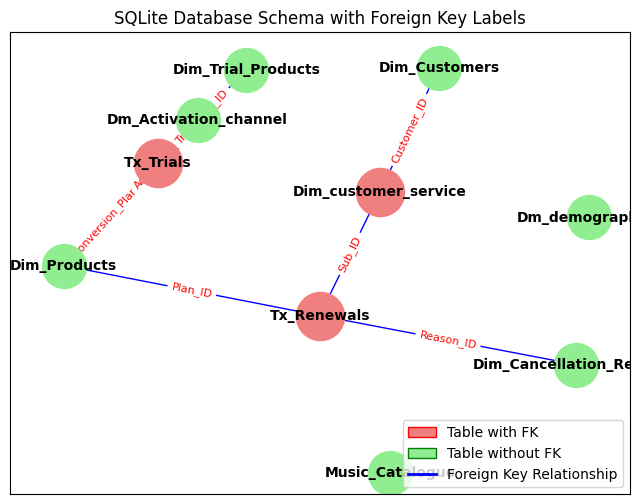

In [32]:
# Function to get table schema (columns and foreign keys)
def get_schema(cursor, table_name):
    # Get columns
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = cursor.fetchall()
    
    # Get foreign keys
    cursor.execute(f"PRAGMA foreign_key_list({table_name});")
    foreign_keys = cursor.fetchall()
    
    return columns, foreign_keys

# Function to get all tables from the database
def get_tables(cursor):
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    return [table[0] for table in cursor.fetchall()]

# Add schema details to the graph, including foreign key names as edge labels
def add_detailed_schema_to_graph(G, cursor):
    # Initialize lists for table types
    tables_with_fk = []
    tables_without_fk = []

    # Loop through tables and categorize them
    tables = get_tables(cursor)
    for table in tables:
        # Add table as a node
        G.add_node(table)
        
        columns, foreign_keys = get_schema(cursor, table)
        
        if foreign_keys:
            tables_with_fk.append(table)
        else:
            tables_without_fk.append(table)
        
        # Add edges for foreign key relationships, with FK names
        for fk in foreign_keys:
            from_table = table
            to_table = fk[2]  # The table it references
            fk_column_name = fk[3]  # Column name that is the foreign key
            G.add_edge(from_table, to_table, color='blue', fk_name=fk_column_name)  # Add FK name as an edge attribute
    
    return tables_with_fk, tables_without_fk

# Function to customize node appearance and handle layout issues, including edge labels for FKs
def draw_detailed_graph(G, tables_with_fk, tables_without_fk):
    plt.figure(figsize=(8, 6))
    
    # Turn off the grid
    plt.grid(False)
    
    # Position layout
    pos = nx.spring_layout(G)  # Ensure layout for all nodes
    
    # Ensure all nodes have a position in the layout
    missing_nodes = [node for node in G.nodes if node not in pos]
    if missing_nodes:
        raise ValueError(f"Missing positions for nodes: {missing_nodes}")
    
    # Color for tables with foreign keys
    nx.draw_networkx_nodes(G, pos, nodelist=tables_with_fk, node_color='lightcoral', node_size=1200)
    
    # Color for tables without foreign keys
    nx.draw_networkx_nodes(G, pos, nodelist=tables_without_fk, node_color='lightgreen', node_size=1000)
    
    # Draw edges
    edges = G.edges(data=True)
    edge_colors = [edge[2]['color'] for edge in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, arrows=True)
    
    # Draw node labels (table names)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    
    # Draw edge labels (foreign key names)
    edge_labels = {(u, v): d['fk_name'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8, label_pos=0.5)
    
    # Create a legend
    legend_elements = [
        Patch(facecolor='lightcoral', edgecolor='r', label='Table with FK'),
        Patch(facecolor='lightgreen', edgecolor='g', label='Table without FK'),
        Line2D([0], [0], color='blue', lw=2, label='Foreign Key Relationship')
    ]
    plt.legend(handles=legend_elements, loc='best')
    
    plt.title('SQLite Database Schema with Foreign Key Labels')    
    plt.savefig("database_schema.png", format="png", bbox_inches="tight")
    plt.show()

# Connect to the SQLite database
conn = sqlite3.connect("/kaggle/working/Sonify_DB.db")
cursor = conn.cursor()

# Create the graph
G = nx.DiGraph()

# Add detailed schema information
tables_with_fk, tables_without_fk = add_detailed_schema_to_graph(G, cursor)

# Close the connection
conn.close()

# Draw the detailed graph
draw_detailed_graph(G, tables_with_fk, tables_without_fk)

In [33]:
# Add schema details to the graph, including foreign key names as edge labels
def add_detailed_schema_to_graph(G, cursor):
    # Initialize lists for table types
    tables_with_fk = []
    tables_without_fk = []

    # Loop through tables and categorize them
    tables = get_tables(cursor)
    for table in tables:
        # Get schema information (columns and foreign keys)
        columns, foreign_keys = get_schema(cursor, table)
        
        # Format column names for the node label
        column_names = [col[1] for col in columns]  # Get column names from the PRAGMA table_info response
        node_label = f"{table}\n" + "\n".join(column_names)  # Combine table and column names
        
        # Add table as a node with the detailed label
        G.add_node(table, label=node_label)
        
        if foreign_keys:
            tables_with_fk.append(table)
        else:
            tables_without_fk.append(table)
        
        # Add edges for foreign key relationships, with FK names
        for fk in foreign_keys:
            from_table = table
            to_table = fk[2]  # The table it references
            fk_column_name = fk[3]  # Column name that is the foreign key
            G.add_edge(from_table, to_table, color='blue', fk_name=fk_column_name)  # Add FK name as an edge attribute
    
    return tables_with_fk, tables_without_fk

In [34]:
# Function to customize node appearance and handle layout issues, including edge labels for FKs
def draw_detailed_graph(G, tables_with_fk, tables_without_fk):
    plt.figure(figsize=(10, 8))
    
    # Turn off the grid
    plt.grid(False)
    
    # Position layout
    pos = nx.spring_layout(G)  # Ensure layout for all nodes
    
    # Color for tables with foreign keys
    nx.draw_networkx_nodes(G, pos, nodelist=tables_with_fk, node_color='lightcoral', node_size=1200)
    
    # Color for tables without foreign keys
    nx.draw_networkx_nodes(G, pos, nodelist=tables_without_fk, node_color='lightgreen', node_size=1000)
    
    # Draw edges
    edges = G.edges(data=True)
    edge_colors = [edge[2]['color'] for edge in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, arrows=True)
    
    # Draw node labels (table and column names)
    labels = {node: data['label'] for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_weight="bold", verticalalignment='center')
    
    # Draw edge labels (foreign key names)
    edge_labels = {(u, v): d['fk_name'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8, label_pos=0.5)
    
    # Create a legend
    legend_elements = [
        Patch(facecolor='lightcoral', edgecolor='r', label='Table with FK'),
        Patch(facecolor='lightgreen', edgecolor='g', label='Table without FK'),
        Line2D([0], [0], color='blue', lw=2, label='Foreign Key Relationship')
    ]
    plt.legend(handles=legend_elements, loc='best')
    
    plt.title('SQLite Database Schema with Table and Column Names')
    plt.savefig("database_schema.png", format="png", bbox_inches="tight")
    plt.show()

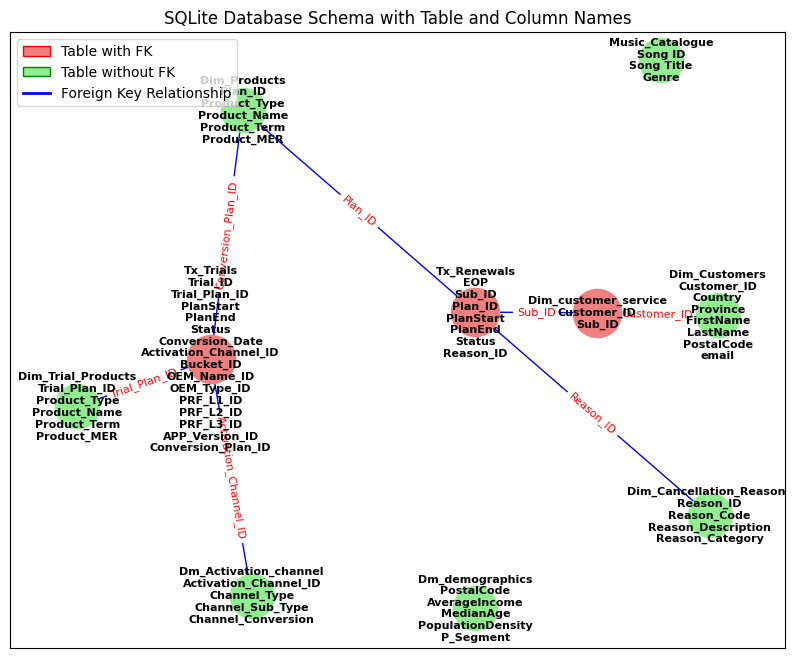

In [35]:
# Function to get table schema (columns and foreign keys)
def get_schema(cursor, table_name):
    # Get columns
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = cursor.fetchall()
    
    # Get foreign keys
    cursor.execute(f"PRAGMA foreign_key_list({table_name});")
    foreign_keys = cursor.fetchall()
    
    return columns, foreign_keys

# Function to get all tables from the database
def get_tables(cursor):
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    return [table[0] for table in cursor.fetchall()]

db_file = "/kaggle/working/Sonify_DB.db"

# Connect to the SQLite database
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Create the graph
G = nx.DiGraph()

# Add detailed schema information
tables_with_fk, tables_without_fk = add_detailed_schema_to_graph(G, cursor)

# Close the connection
conn.close()

# Draw the detailed graph
draw_detailed_graph(G, tables_with_fk, tables_without_fk)

# GENERATE A FILE FOR EACH MONTH OF THE EOP

In [36]:
!mkdir Tx_Renewals_CSV

In [37]:
con = sqlite3.connect(file_path) 
Tx_Renewals_df = pd.read_sql_query("""SELECT * from Tx_Renewals""", con)
con.close()

eop_dates = Tx_Renewals_df['EOP'].unique()
for date in eop_dates:
    df_filtered = Tx_Renewals_df[Tx_Renewals_df['EOP'] == date]
    df_filtered.to_csv(f'Tx_Renewals_CSV/eop_date_{date}.csv', index=False)